In [215]:
import math
import copy
import random
import datetime
from collections import defaultdict
from enum import Enum
import numpy as np 
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import gymnasium
from typing import (
    Type,
    List,
    Tuple,
)
import matplotlib.pyplot as plt
from sb3_contrib import RecurrentPPO
from stable_baselines3 import PPO, A2C
import wandb

- See if there is transfer from learning regression models from a couple different sine curves to yet a different sine curve.
- We know there is transfer is (1) it takes less to train and (2) if the model chooses to reuse layers rather than create new ones.
- We first train regression models without the meta-learner (because the 'meta' ability cannot do anything without pre-trained weights).
- The meta-learner will then output actions to build a model for unseen data.
- Actions will be continuous, a vector of probabilities corresponding to which layer to add from the layer pool. One of these probabilities corresponds to adding no layer and just training the architecture as it is.

## config

In [233]:
default_config = {
    'seed' : 41,
    'device' : 'cuda',
    'pretrain' : False,
    'epochs' : 1,
    'timesteps' : 1000,
    'n_x' : 100,
    'n_tasks' : 3,
    'in_features' : 1,
    'out_features' : 1,
    'n_pool_hidden_layers' : 10,
    'n_hidden_layers_per_network' : 3,
    'n_layers_per_network' : 5,
    'n_nodes_per_layer' : 40,
    'pool_layer_type' : torch.nn.Linear,
    'batch_size' : 100,
    'learning_rate' : 0.05,
    'action_cache_size' : 5,
    'num_workers' : 0,
    'loss_fn' : torch.nn.MSELoss(),
    'sb3_model' : 'RecurrentPPO',
    'sb3_policy' : 'MlpLstmPolicy',
    'log_dir' : 'wandb',
    }
config = default_config
config['n_pool_hidden_layers'] = config['n_tasks'] * config['n_hidden_layers_per_network']
config

{'seed': 41,
 'device': 'cuda',
 'pretrain': False,
 'epochs': 1,
 'timesteps': 1000,
 'n_x': 100,
 'n_tasks': 3,
 'in_features': 1,
 'out_features': 1,
 'n_pool_hidden_layers': 9,
 'n_hidden_layers_per_network': 3,
 'n_layers_per_network': 5,
 'n_nodes_per_layer': 40,
 'pool_layer_type': torch.nn.modules.linear.Linear,
 'batch_size': 100,
 'learning_rate': 0.05,
 'action_cache_size': 5,
 'num_workers': 0,
 'loss_fn': MSELoss(),
 'sb3_model': 'RecurrentPPO',
 'sb3_policy': 'MlpLstmPolicy',
 'log_dir': 'wandb'}

In [111]:
wandb.init(
    project='reinforcement-meta-learning',
    config=config
)

loss_per_episode,█▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
num_layers_task0_per_step,▃▁▆▃▆▆▆▁▆▁▁▆▆▃▃▁▆▃▆▆▁▆▆▆▃▁▆▆▃▆▆▆▆▆▃▆▆▃█▆
total_reward_per_epoch_across_tasks,▁█
loss_per_episode,0.00588
num_layers_task0_per_step,4
total_reward_per_epoch_across_tasks,-90


In [234]:
torch.cuda.is_available()

True

## Reinforcement Meta-Learning (REML) / "Learning to Learn by Gradient Descent as a Markov Decision Process"

### sinusoidal curve regression as in MAML 2018 paper

In [235]:
lower_bound = torch.tensor(-5).float()
upper_bound = torch.tensor(5).float()
X = np.linspace(lower_bound, upper_bound, config['n_x'])
amplitude_range = torch.tensor([0.1, 5.0]).float()
phase_range = torch.tensor([0, math.pi]).float()
amps = torch.from_numpy(np.linspace(amplitude_range[0], amplitude_range[1], config['n_tasks'])).float()
phases = torch.from_numpy(np.linspace(phase_range[0], phase_range[1], config['n_tasks'])).float()
tasks_data = torch.tensor(np.array([ 
        X
        for _ in range(config['n_tasks'])
        ])).float()
tasks_targets = torch.tensor(np.array([
        [((a * np.sin(x)) + p).float()
        for x in X] 
        for a, p in zip(amps, phases)
        ])).float()
tasks_info = [
        {'i' : i, 
         'amp' : a, 
         'phase_shift' : p, 
         'lower_bound' : lower_bound, 
         'upper_bound' : upper_bound, 
         'amplitude_range_lower_bound' : amplitude_range[0], 
         'amplitude_range_upper_bound' : amplitude_range[1], 
         'phase_range_lower_bound' : phase_range[0],
         'phase_range_lower_bound' : phase_range[1]}
        for i, (a, p) in enumerate(zip(amps, phases))
]
print(f'[INFO] Tasks created.')

[INFO] Tasks created.


In [236]:
print(tasks_data.shape)
print(tasks_data.dtype)
print(tasks_targets.shape)
print(tasks_targets.dtype)
print(len(tasks_info))
print(len(tasks_info[0]))

torch.Size([3, 100])
torch.float32
torch.Size([3, 100])
torch.float32
3
8


In [237]:
class RegressionModel(torch.nn.Module):
    def __init__(self):
        super(RegressionModel, self).__init__()
        self.layers = torch.nn.ModuleList([
            torch.nn.Linear(config['in_features'], 40),  
            torch.nn.Linear(40, 40), 
            torch.nn.Linear(40, 40),  
            torch.nn.Linear(40, 40),  
            torch.nn.Linear(40, config['out_features'])  
        ])
        [torch.nn.init.xavier_uniform_(layer.weight) for layer in self.layers]

    def forward(self, x):
        for i in range(len(self.layers)-1):
            x = torch.nn.functional.relu(self.layers[i](x))
        x = self.layers[-1](x)
        return x


In [238]:
if config['pretrain']:
    layers = []
    data = []
    for x, y in zip(tasks_data, tasks_targets):
        data.append([x,y])
    for i, (x, y) in enumerate(data):
        print(f'[INFO] Pre-training for task {i+1}')
        model = RegressionModel()
        criterion = torch.nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'])
        num_epochs = 10000
        model.train()
        for epoch in range(num_epochs):
            optimizer.zero_grad() 
            outputs = model(x.view(-1, 1))
            loss = criterion(outputs, y.view(-1,1))
            loss.backward()
            optimizer.step()

        # save layers for layer pool
        layers.extend(model.layers[1:-1])

In [239]:
pool = LayerPool(layers=layers) if config['pretrain'] else LayerPool(layers=None)
test_layers = [pool.initial_layer, *layers[0:3], pool.final_layer]

class RegressionModel(torch.nn.Module):
    def __init__(self):
        super(RegressionModel, self).__init__()
        self.layers = torch.nn.ModuleList(test_layers)
        [torch.nn.init.xavier_uniform_(layer.weight) for layer in self.layers]

    def forward(self, x):
        for i in range(len(self.layers)-1):
            x = torch.nn.functional.relu(self.layers[i](x))
        x = self.layers[-1](x)
        return x

model = RegressionModel()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'])
model.train()
x, y = tasks_data[0], tasks_targets[0]
for epoch in range(100):
    optimizer.zero_grad() 
    outputs = model(x.view(-1, 1))
    loss = criterion(outputs, y.view(-1,1))
    loss.backward()
    optimizer.step()
    print(loss)

tensor(0.0051, grad_fn=<MseLossBackward0>)
tensor(1.0659, grad_fn=<MseLossBackward0>)
tensor(0.6393, grad_fn=<MseLossBackward0>)
tensor(0.0374, grad_fn=<MseLossBackward0>)
tensor(0.0121, grad_fn=<MseLossBackward0>)
tensor(0.0069, grad_fn=<MseLossBackward0>)
tensor(0.0064, grad_fn=<MseLossBackward0>)
tensor(0.0060, grad_fn=<MseLossBackward0>)
tensor(0.0057, grad_fn=<MseLossBackward0>)
tensor(0.0055, grad_fn=<MseLossBackward0>)
tensor(0.0054, grad_fn=<MseLossBackward0>)
tensor(0.0052, grad_fn=<MseLossBackward0>)
tensor(0.0071, grad_fn=<MseLossBackward0>)
tensor(0.0045, grad_fn=<MseLossBackward0>)
tensor(0.0047, grad_fn=<MseLossBackward0>)
tensor(0.0048, grad_fn=<MseLossBackward0>)
tensor(0.0048, grad_fn=<MseLossBackward0>)
tensor(0.0048, grad_fn=<MseLossBackward0>)
tensor(0.0050, grad_fn=<MseLossBackward0>)
tensor(0.0048, grad_fn=<MseLossBackward0>)
tensor(0.0048, grad_fn=<MseLossBackward0>)
tensor(0.0050, grad_fn=<MseLossBackward0>)
tensor(0.0047, grad_fn=<MseLossBackward0>)
tensor(0.00

In [240]:
class LayerPool:
    def __init__(self, 
                size: int=config['n_pool_hidden_layers'], 
                layer_constructor: Type[torch.nn.Linear]=config['pool_layer_type'],
                in_features: int=config['in_features'],
                out_features: int=config['out_features'],
                num_nodes_per_layer: int=config['n_nodes_per_layer'],
                layers: List[torch.nn.Linear]=None):
        self.size = size if layers is None else len(layers)
        self.layer_constructor = layer_constructor
        self.in_features = in_features
        self.out_features = out_features
        self.num_nodes_per_layer = num_nodes_per_layer
        self.initial_layer = self.layer_constructor(in_features=in_features, out_features=num_nodes_per_layer)
        self.final_layer = self.layer_constructor(in_features=num_nodes_per_layer, out_features=out_features)
        torch.nn.init.xavier_uniform_(self.initial_layer.weight)
        torch.nn.init.xavier_uniform_(self.final_layer.weight)

        if layers is None:
            self.layers = [self.layer_constructor(in_features=num_nodes_per_layer, out_features=num_nodes_per_layer)for _ in range(size)]
            [torch.nn.init.xavier_uniform_(layer.weight) for layer in self.layers]
        else:
            self.layers = layers
            config['n_pool_hidden_layers'] = len(self.layers)
        
    def __str__(self) -> str:
        return f"LayerPool(size={self.size}, layer_type={config['pool_layer_type']}, num_nodes_per_layer={config['n_nodes_per_layer']}"


In [241]:
class InnerNetworkAction(Enum):
    ADD = 0
    ERROR = 1

In [242]:
class InnerNetworkTask(Dataset):
    def __init__(self, data, targets, info):
        self.data = data 
        self.targets = targets
        self.info = info

    def __len__(self):
        assert len(self.data) == config['n_x'], '[ERROR] Length should be the same as n_x.'
        return len(self.data)

    def __getitem__(self, index):
        assert self.data[index].dtype == torch.float32, f'[ERROR] Expected type torch.float32, got type: {self.data[index].dtype}'
        assert self.targets[index].dtype == torch.float32, f'[ERROR] Expected type torch.float32, got type: {self.targets[index].dtype}'
        sample = {
            'x' : self.data[index],
            'y' : self.targets[index],
            'info' : self.info
        }
        return sample
    
    def __str__(self):
        return f'[INFO] InnerNetworkTask(data={self.data}, targets={self.targets}, info={self.info})'

In [243]:
def get_params_and_gradients(layers):
    num_layers = len(layers)
    max_num_hidden_layers = config['n_hidden_layers_per_network']
    num_hidden_layers = num_layers - 2
    hidden_layers = layers[1:-1]
    params = [layer.weight.detach() for layer in hidden_layers]
    gradients = [layer.weight.grad for layer in hidden_layers]
    if num_hidden_layers < config['n_hidden_layers_per_network']:
        zero_pad = [torch.zeros((config['n_nodes_per_layer'], config['n_nodes_per_layer']), dtype=torch.float32)] * (max_num_hidden_layers - num_hidden_layers)
        zero_pad_tensor = torch.stack(zero_pad)
        if len(params) > 0 and len(gradients) > 0:
            params = torch.stack(params)
            gradients = torch.stack(gradients)
            params = torch.cat((params, zero_pad_tensor))
            gradients = torch.cat((gradients, zero_pad_tensor)) 
        else:
            params = zero_pad_tensor
            gradients = zero_pad_tensor
    else:
        params = torch.stack(params)
        gradients = torch.stack(gradients)
    assert params.shape==(max_num_hidden_layers, config['n_nodes_per_layer'], config['n_nodes_per_layer']), f"[ERROR] Expected params shape={max_num_hidden_layers, config['n_nodes_per_layer'], config['n_nodes_per_layer']}, got {params.shape}"
    return params.view(-1), gradients.view(-1)

In [244]:
def get_latent_space(latent_space):
    flattened_latent_space = latent_space.view(-1)
    flattened_size = flattened_latent_space.numel()
    target_size = config['batch_size'] * config['n_nodes_per_layer']
    if flattened_size < target_size:
        num_elements_to_pad = target_size - flattened_size
        padding_tensor = torch.zeros(num_elements_to_pad)
        padded_tensor = torch.cat((flattened_latent_space, padding_tensor), dim=0)
        return padded_tensor
    else:
        return flattened_latent_space

In [282]:
class InnerNetwork(gymnasium.Env, torch.nn.Module):
    def __init__(self, 
                task: InnerNetworkTask,
                layer_pool: LayerPool,
                epoch: int=0,
                in_features: int=config['in_features'],
                out_features: int=config['out_features'],
                learning_rate: float=config['learning_rate'],
                batch_size: int=config['batch_size'],
                num_workers: int=config['num_workers'],
                shuffle: bool=True,
                ):
        super(InnerNetwork, self).__init__()
        self.epoch = epoch
        self.learning_rate = learning_rate
        self.layer_pool = layer_pool
        self.task = task
        self.in_features = in_features
        self.out_features = out_features
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.num_workers = num_workers
        self.prev = defaultdict(lambda: None)
        self.curr = defaultdict(lambda: None)
        self.data_loader = DataLoader(task, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
        self.data_iter = iter(self.data_loader)
        self.initial_layer = copy.deepcopy(self.layer_pool.initial_layer)
        self.final_layer = copy.deepcopy(self.layer_pool.final_layer)
        self.layers = torch.nn.ModuleList([self.initial_layer, self.final_layer]) 
        self.layers_pool_indices = []
        self.loss_fn = torch.nn.MSELoss()
        self.opt = torch.optim.Adam(self.layers.parameters(), lr=self.learning_rate)
        self.timestep = 0
        self.epoch_reward = 0 
        self.cum_loss = 0
        self.cum_reward = 0
        self.min_loss = None
        self.train()
        self.next_batch()
        self.forward(self.curr['x'])
        # loss = self.curr['loss']
        # loss.backward()
        self.observation_space = gymnasium.spaces.box.Box(low=float('-inf'), high=float('inf'), shape=self.build_state().shape)
        self.action_space = gymnasium.spaces.discrete.Discrete(len(self.layer_pool.layers))

    def step(self, action: np.int64) -> Tuple[torch.Tensor, float, bool, dict]: 
        self.timestep += 1
        self.next_batch()

        self.update_inner_network(action)
        self.forward(self.curr['x'])
        s_prime = self.build_state()

        if len(self.layers)==config['n_layers_per_network']:
            self.train_inner_network()
            termination = True
            print(f"{self.layers_pool_indices}={self.curr['loss']}")
        else:
            termination = False

        reward = self.reward()
        self.log()

        return (
            s_prime,
            reward, 
            termination,
            False,
            {}
        )
    
    # def soft_reset(self):
    #     self.initial_layer = copy.deepcopy(self.layer_pool.initial_layer)
    #     self.final_layer = copy.deepcopy(self.layer_pool.final_layer)
    #     self.layers = torch.nn.ModuleList([self.initial_layer, self.final_layer]) 
    #     self.layers_pool_indices = []
    #     self.loss_fn = torch.nn.MSELoss()
    #     self.opt = torch.optim.Adam(self.layers.parameters(), lr=self.learning_rate)
    
    def update_inner_network(self, action: np.int64) -> None:
        if action in self.layers_pool_indices:
            self.curr['action_type'] = InnerNetworkAction.ERROR
        else:
            self.curr['action_type'] = InnerNetworkAction.ADD
        if (self.curr['action_type']==InnerNetworkAction.ADD): 
            new_layer = self.layer_pool.layers[action]
            final_layer = self.layers.pop(-1) 
            self.layers.append(new_layer)
            self.layers.append(final_layer) 
            if isinstance(action, np.ndarray):
                action = action.item()
            self.layers_pool_indices.append(action)
            
    def next_batch(self, throw_exception=False) -> None:
        self.prev = self.curr
        self.curr = defaultdict(lambda: None)

        if (throw_exception):
            batch = next(self.data_iter)
            self.curr['x'] = batch['x'].view(-1, 1)
            self.curr['y'] = batch['y'].view(-1, 1)
            self.curr['info'] = batch['info']
        else: 
            try:
                batch = next(self.data_iter)
            except StopIteration:
                self.data_loader = DataLoader(self.task, batch_size=self.batch_size, shuffle=self.shuffle, num_workers=self.num_workers)
                self.data_iter = iter(self.data_loader)
                batch = next(self.data_iter)
            finally:
                self.curr['x'] = batch['x'].view(-1, 1)
                self.curr['y'] = batch['y'].view(-1, 1)
                self.curr['info'] = batch['info']
    
    def train_inner_network(self) -> None: 
        self.train()
        self.opt = torch.optim.Adam(self.layers.parameters(), lr=self.learning_rate) 
        for _ in range(50):
            self.next_batch()
            self.opt.zero_grad()
            x = copy.deepcopy(self.curr['x'])
            for i in range(len(self.layers) - 1): 
                x = torch.nn.functional.relu(self.layers[i](x))
            self.curr['latent_space'] = x
            self.curr['y_hat'] = self.layers[-1](x) 
            y = self.curr['y']
            self.curr['loss'] = self.loss_fn(y, self.curr['y_hat'])
            loss = self.curr['loss']
            self.curr['loss'].backward()
            self.opt.step()

    def forward(self, x) -> torch.tensor:
        self.eval()
        for i in range(len(self.layers) - 1): 
            x = torch.nn.functional.relu(self.layers[i](x))
        self.curr['latent_space'] = x
        self.curr['y_hat'] = self.layers[-1](x) 
        y = self.curr['y']
        self.curr['loss'] = self.loss_fn(y, self.curr['y_hat'])
        # self.curr['loss'].backward() # calculate gradients
        return self.curr['y_hat']
    
    def build_state(self) -> np.ndarray:
        task_info = torch.tensor([self.task.info['amp'], self.task.info['phase_shift']]).squeeze()
        loss = torch.Tensor([self.curr['loss']])
        latent_space = get_latent_space(self.curr['latent_space'])
        # _, gradients = get_params_and_gradients(self.layers)
        one_hot_layers = torch.tensor(np.array([1 if self.layer_pool.layers[i] in self.layers else 0 for i in range(len(self.layer_pool.layers))]))
        layer_indices = copy.deepcopy(self.layers_pool_indices)
        while len(layer_indices) < config['n_hidden_layers_per_network']:
            layer_indices.insert(0, 0)
        layer_indices = torch.tensor(layer_indices)
        
        return torch.concat((
            task_info,
            latent_space,
            layer_indices,
            one_hot_layers,
            loss,
            # gradients,
        ), dim=0).detach().numpy()
    
    def reward(self) -> torch.Tensor:
        # if self.curr['action_type']==InnerNetworkAction.ERROR:
        #     self.curr['reward'] = -1
        # elif len(self.layers)==config['n_layers_per_network']:
        #     # prev_loss = self.prev['loss'] or None
        #     # curr_loss = self.curr['loss']
        #     # loss_delta = prev_loss - curr_loss if prev_loss is not None else curr_loss
        #     self.min_loss = self.curr['loss'] if self.min_loss==None else self.min_loss
        #     if self.curr['loss'] < self.min_loss:
        #         self.min_loss = self.curr['loss']
        #         self.curr['reward'] = 5
        #     else:
        #         self.curr['reward'] = -1
        #     print(f"[INFO] min_loss={self.min_loss}, curr_loss={self.curr['loss']}, reward{self.curr['reward']}")
        # else:
        #     self.curr['reward'] = 0
        # print(f"[INFO] Reward={self.curr['reward']}.")
        # return self.curr['reward']
        if self.curr['action_type']==InnerNetworkAction.ERROR:
            self.curr['reward'] = -2
            return -2
        else:
            self.curr['reward'] = -self.curr['loss']
            return self.curr['loss']

    def log(self):
        # task_num = str(self.curr['info']['i'].item())
        task_num = 0
        self.cum_loss += self.curr['loss']
        self.cum_reward += self.curr['reward']
        self.epoch_reward += self.curr['reward']
        if len(self.layers_pool_indices)>0:
            wandb.log({ f'pool_indices_task{task_num}_per_step' : wandb.Histogram(copy.deepcopy(self.layers_pool_indices))})
        wandb.log({ f'num_layers_task{task_num}_per_step' : len(self.layers) })

    def reset(self, seed=None) -> np.ndarray:
        # print(f'[INFO] Reset at {self.timestep}')
        wandb.log({ f'loss_per_episode' : self.curr['loss'] })
        self.timestep = 0
        self.cum_reward = 0
        self.cum_loss = 0
        self.layers = torch.nn.ModuleList([self.initial_layer, self.final_layer]) 
        self.layers_pool_indices = []
        self.train()
        self.next_batch()
        self.forward(self.curr['x'])
        loss = self.curr['loss']
        # loss.backward()
        return self.build_state(), None

In [283]:
class REML:
    def __init__(
        self,
        layer_pool: LayerPool,
        tasks: List[InnerNetworkTask],
        model=config['sb3_model'],
        policy=config['sb3_policy'],
        epochs: int=config['epochs'],
        timesteps: int=config['timesteps'],
        device: str=config['device'],
        log_dir: str=f"./{config['log_dir']}/{config['sb3_model']}_{datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}"
        ):
        self.tasks = tasks
        self.global_pool = layer_pool
        self.local_pools = { task: copy.deepcopy(layer_pool) for task in tasks }
        if config['sb3_model']=='PPO':
            model = PPO
        elif config['sb3_model']=='A2C':
            model = A2C
        elif config['sb3_model']=='RecurrentPPO':
            model = RecurrentPPO
        dummy_env = self.make_env(tasks[0], layer_pool)
        self.model = model(policy, dummy_env, tensorboard_log=log_dir, n_epochs=5, batch_size=32, n_steps=32)
        # self.model = model(policy, dummy_env, tensorboard_log=log_dir)
        self.policy = policy
        self.epochs = epochs
        self.timesteps = timesteps
        self.device = device # TODO is to check whether cuda is used as assumed
        self.log_dir = log_dir

    
    def __str__(self) -> str:
        return f'REML(model={self.model}, policy={self.policy})'
    
    def make_env(self, task, epoch=None) -> gymnasium.Env:
        return gymnasium.wrappers.NormalizeObservation(InnerNetwork(task, self.local_pools[task], epoch=epoch))

    def train(self):
        # wraps stablebaselines learn() so we call it n * m times
        # n is the number of epochs where we run all m tasks
        # we use the same policy, swapping out envs for the n tasks, m times. 
        for epoch in range(self.epochs):
            print(f'[INFO] Epoch={epoch+1}/{self.epochs}')

            epoch_reward = 0
            for i, task in enumerate(self.tasks): 
                self.task = task
                print(f'[INFO] Task={i+1}/{len(self.tasks)}')

                # each task gets its own network
                self.env = self.make_env(self.task, epoch=epoch)
                self.model.set_env(self.env)
                self.model.learn(total_timesteps=self.timesteps)

		        # pool update
                for index, layer in zip(self.env.layers_pool_indices, self.env.layers[1:-1]):
                    self.local_pools[task].layers[index] = layer
                #     env_layer_params = [param.data.clone() for param in self.env.layers[1:-1].parameters()]
                #     corresponding_pool_layer_params = [param.data.clone() for param in torch.nn.ModuleList([self.local_pools[task].layers[index] for index in self.env.layers_pool_indices]).parameters()]
                #     for param_before, param_after in zip(env_layer_params, corresponding_pool_layer_params):
                #         if not torch.all(torch.eq(param_before, param_after)):
                #             print('[ERROR] Layers in pool not updated.')
                
                epoch_reward += self.env.epoch_reward

                # sine curves
                self.generate_sine_curve(epoch=epoch, task=i, image=True, args={'label' : f'task_{i}'}, new_figures=True)

            # wandb per epoch
            wandb.log({ f'total_reward_per_epoch_across_tasks' : self.env.epoch_reward})
    
    def evaluate_loss_curves(self, steps=100) -> dict:
        # generates loss curve over 'steps' per task

        lossperstep_bytask = defaultdict(lambda: [])

        for task in self.tasks: 
            env = gymnasium.wrappers.NormalizeObservation(InnerNetwork(task, self.layer_pool))
            self.model.set_env(env, force_reset=False)
            obs, _ = env.reset()

            while len(env.layers) < config['n_layers_per_network']:
                action, _ = self.model.predict(obs)
                obs, _, _, _, _ = env.step(action)

            for _ in range(steps):
                action, _ = self.model.predict(obs)
                obs, _, _, _, _ = env.step(action)
                env.next_batch()
                yhats = env.forward(env.curr['x'])
                loss = env.loss_fn(yhats, env.curr['y'] )
                lossperstep_bytask[task].append(loss)

        return lossperstep_bytask

    def generate_sine_curve(self, env=None, data=None, epoch=None, task=None, image=False, new_figures=False, title=None, args=defaultdict()) -> List:
        # generates sine curve after 'env.layers' is full, with option to set env, limit to 
        # subset of env data (for few shot evaluation), and to create png

        if env is not None:
            self.env = env
            self.model.set_env(env, force_reset=False)

        self.env.eval()
        obs, _ = self.env.reset()
        
        while len(self.env.layers)!=config['n_layers_per_network']:
            action, _ = self.model.predict(obs)
            obs, _, _, _, _ = self.env.step(action)
        
        print()        
        print(self.env.layers)
        print(self.env.layers_pool_indices)
        print([layer.weight.detach() for layer in self.env.layers])
        print()        

        # if data is specified, wrap in new task
        # if data is not specified, the iterator is used over set
        if data is not None:
            dataset = InnerNetworkTask(data=data[:, 0].clone(), targets=data[:, 1].clone(), info=self.task.info)
        else: 
            dataset = self.task

        xs = dataset.data.clone()
        xs = xs.view(len(xs), 1)
        ys = dataset.targets.clone()
        ys = ys.view(len(ys), 1)
        for i in range(len(self.env.layers) - 1): 
            xs = torch.nn.functional.relu(self.env.layers[i](xs))
        yhats = self.env.layers[-1](xs) 
        print(yhats)
        print(f'loss={self.env.loss_fn(yhats, ys)}')

        if new_figures:
            plt.figure()
        plot_title = title if title!=None else f'sine_curve_epoch_{epoch}_task_{task}' if epoch!=None and task!=None else 'sine_curve'
        plot_path = f'{self.log_dir}/{plot_title}.png'  
        plt.plot(dataset.data, [yhat.detach().numpy() for yhat in yhats], **args)
        plt.plot(dataset.data, dataset.targets, label='ground truth', linestyle='--')
        plt.title(plot_title)
        plt.legend()

        if image:
            plt.savefig(plot_path)
            wandb.log({plot_title: wandb.Image(plot_path)})
       
        xs, yhats = dataset.data, [yhat.detach().numpy() for yhat in yhats]
        return xs, yhats

### testing

In [284]:
tasks = [InnerNetworkTask(data=tasks_data[i], targets=tasks_targets[i], info=tasks_info[i]) for i in range(config['n_tasks'])]
# eval_task = random.choice(list(tasks))
# training_tasks = list(set(tasks) - {eval_task})
pool = LayerPool(layers=layers) if config['pretrain'] else LayerPool(layers=None)
reml = REML(layer_pool=pool, tasks=tasks)

In [285]:
reml.__str__()

'REML(model=<sb3_contrib.ppo_recurrent.ppo_recurrent.RecurrentPPO object at 0x000002BF012B2AD0>, policy=MlpLstmPolicy)'

In [286]:
config

{'seed': 41,
 'device': 'cuda',
 'pretrain': False,
 'epochs': 1,
 'timesteps': 1000,
 'n_x': 100,
 'n_tasks': 3,
 'in_features': 1,
 'out_features': 1,
 'n_pool_hidden_layers': 9,
 'n_hidden_layers_per_network': 3,
 'n_layers_per_network': 5,
 'n_nodes_per_layer': 40,
 'pool_layer_type': torch.nn.modules.linear.Linear,
 'batch_size': 100,
 'learning_rate': 0.05,
 'action_cache_size': 5,
 'num_workers': 0,
 'loss_fn': MSELoss(),
 'sb3_model': 'RecurrentPPO',
 'sb3_policy': 'MlpLstmPolicy',
 'log_dir': 'wandb'}

[INFO] Epoch=1/1
[INFO] Task=1/3
[8, 6, 1]=0.0055638644844293594
[3, 4, 2]=0.0035203469451516867
[7, 3, 5]=0.003261004574596882
[4, 1, 2]=0.00014303957868833095
[4, 5, 2]=0.0022461283951997757
[1, 7, 8]=0.004017658066004515
[0, 5, 8]=4.825856376555748e-05
[3, 7, 2]=0.004069567192345858
[8, 6, 4]=0.00531105138361454
[7, 3, 0]=0.004076613113284111
[8, 2, 7]=0.005315076559782028
[6, 7, 5]=0.00531371496617794
[0, 5, 6]=0.002673512790352106
[6, 3, 1]=0.0026741614565253258
[1, 6, 0]=0.004801807925105095
[7, 4, 5]=0.005324031226336956
[7, 3, 1]=0.005332267377525568
[0, 6, 5]=0.005320416763424873
[4, 6, 8]=0.0053179278038442135
[4, 5, 6]=0.005310328211635351
[8, 3, 2]=0.005318206734955311
[0, 1, 2]=0.005315093789249659
[4, 8, 3]=0.005323483143001795
[4, 0, 2]=0.005314886104315519
[3, 0, 5]=0.005323560442775488
[8, 7, 4]=0.00531355245038867
[4, 1, 3]=0.005323467776179314
[5, 4, 6]=0.00531375827267766
[0, 1, 7]=0.005323648918420076
[3, 1, 2]=0.005314385984092951
[2, 8, 7]=0.005323654972016811
[8

KeyboardInterrupt: 

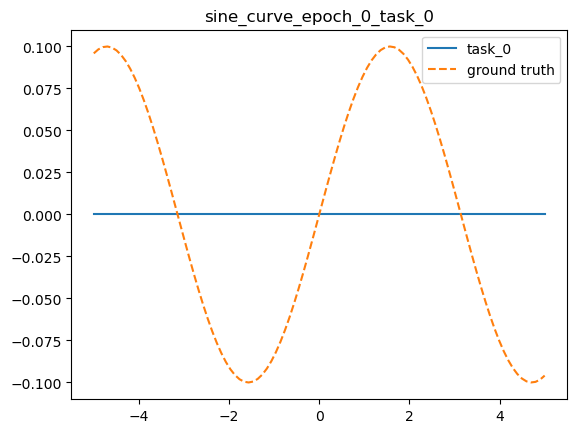

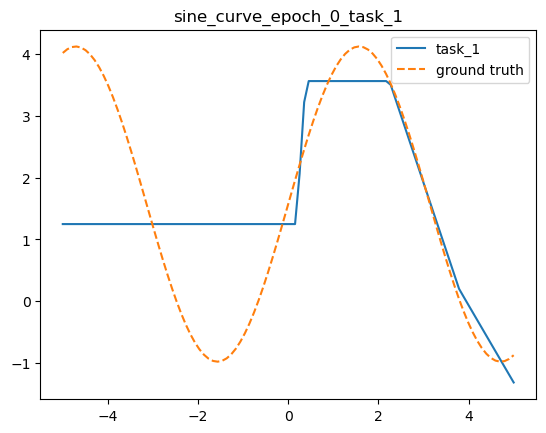

In [287]:
reml.train()
path = f"meta_{config['sb3_model']}_{datetime.datetime.now().strftime('%H-%M')}"
reml.model.save(path)

### meta analysis

#### speed of training test

In [241]:
# get loss for meta trained network per step
reml = REML(layer_pool=pool, tasks=tasks)
reml.model.load(path)
meta_lossperstep_bytask = reml.evaluate_loss_curves()

# get loss for vanilla network per step
vanilla_lossperstep_bytask = {}
for task, x, y in zip(tasks, tasks_data, tasks_targets):
    model = RegressionModel()
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    model.train()
    vanilla_lossperstep_bytask[task] = []
    for epoch in range(100):
        optimizer.zero_grad() 
        outputs = model(x.view(-1, 1))
        loss = criterion(outputs, y.view(-1,1))
        loss.backward()
        optimizer.step()
        vanilla_lossperstep_bytask[task].append(loss)


[INFO] Reset at 0
[INFO] Reset at 0
[INFO] Reset at 0
[INFO] Reset at 0
[INFO] Reset at 0
[INFO] Reset at 0


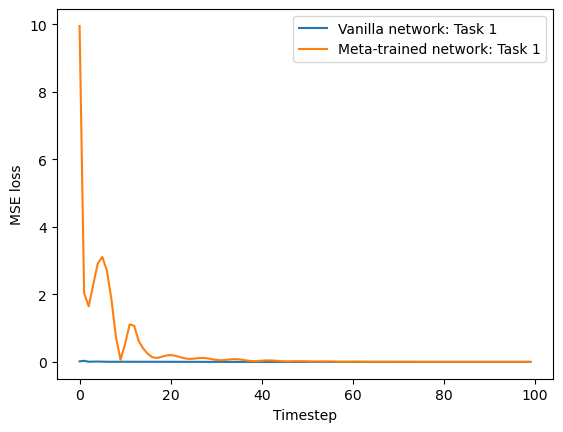

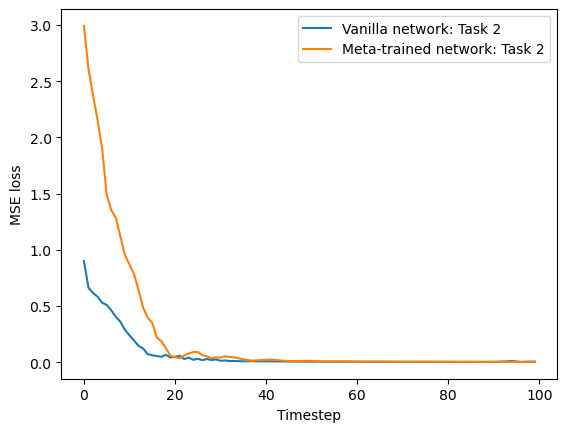

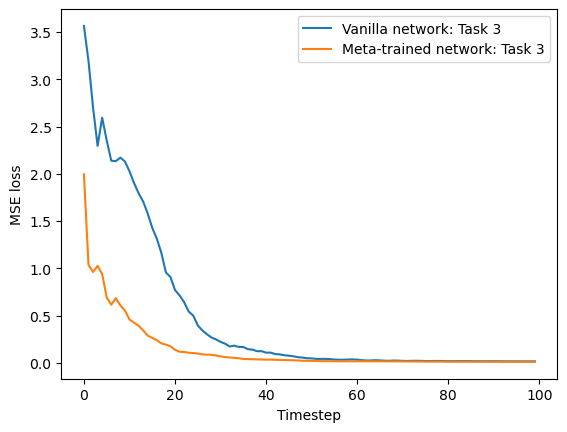

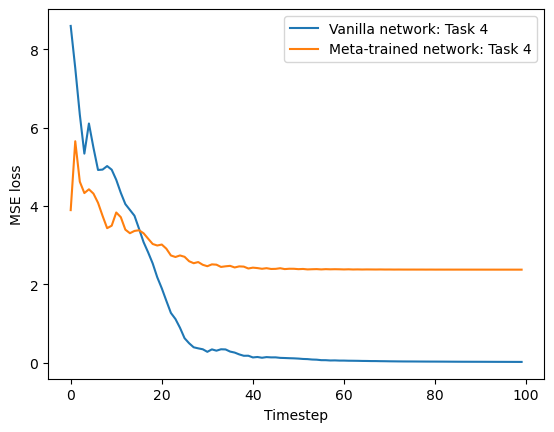

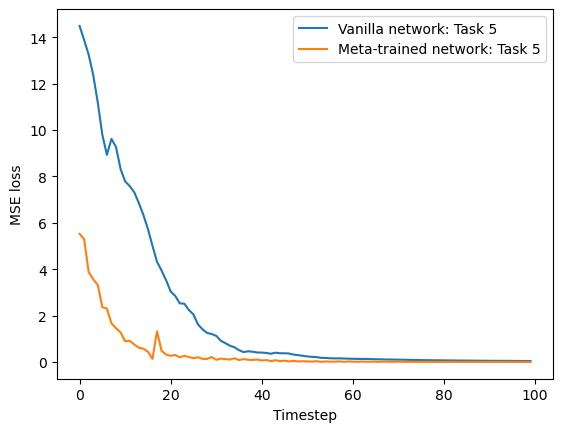

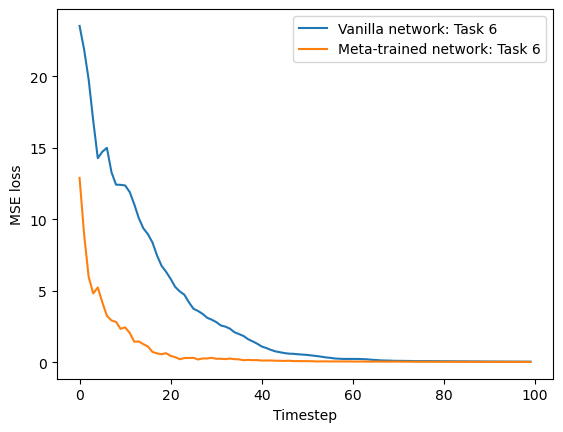

In [242]:
for i, (x, y) in enumerate(zip(tasks_data, tasks_targets)):
    task = tasks[i]
    vanilla_label = f'Vanilla network: Task {i+1}' 
    meta_label = f'Meta-trained network: Task {i+1}' 
    meta_loss_vals = [val.detach().numpy() for val in meta_lossperstep_bytask[task]]
    vanilla_loss_vals = [val.detach().numpy() for val in vanilla_lossperstep_bytask[task]]
    plt.plot(range(100), vanilla_loss_vals, label=vanilla_label)
    plt.plot(range(100), meta_loss_vals, label=meta_label)
    plt.xlabel('Timestep')
    plt.ylabel('MSE loss')
    plt.legend()
    plt.show()


#### few shot learning tests

k=5

In [243]:
# unseen task
# choose 5 and 10 datapoints on it, K = 5, K = 10
k = 5
k_pairs = torch.tensor(random.sample(list(zip(eval_task.data, eval_task.targets)), k))
print(len(k_pairs))
print(k_pairs)

# network still recieves the same 100 x values {-5, ..., 5}
# the difference is that a target value is only provided for 5 or 10 of these 100 values
# start by generating the 'pre-update' curve 
# next pass k datapoints and do 1 gradient update step to get the curve
# next do 9 more gradient update steps (total 10) to get next curve
# plot 'pre-update', '1 grad step', '10 grad steps' curves together with the 'k_pairs' data points

5
tensor([[-0.0505,  0.5738],
        [ 4.1919, -0.3087],
        [-0.1515,  0.4653],
        [-0.8586, -0.1892],
        [-1.6667, -0.4467]])


[INFO] Reset at 0
[INFO] Reset at 4
[INFO] Reset at 1
[INFO] Reset at 0
[INFO] Reset at 10


Text(0.5, 1.0, 'REML, k=5')

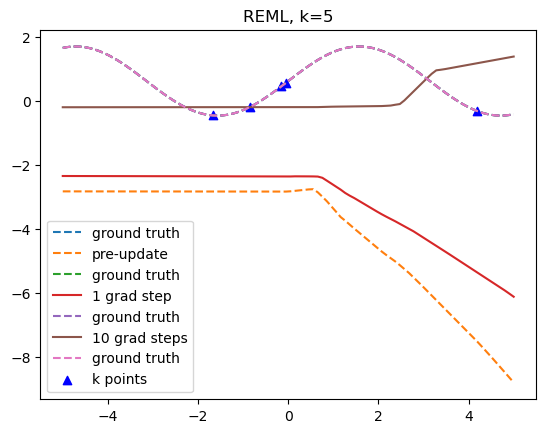

In [244]:
# env with eval task
reml = REML(layer_pool=pool, tasks=tasks)
reml.model.load(path)
env = reml.make_env(eval_task, pool)
reml.model.set_env(env)
reml.env = env
reml.task = eval_task

# ground truth
plt.plot(eval_task.data, eval_task.targets, linestyle='--', label='ground truth')

# pre-update
reml.generate_sine_curve(env=env, args={'linestyle' : '--', 'label': 'pre-update'})

# k points 
plt.scatter(k_pairs[:, 0], k_pairs[:, 1], marker='^', color='b', label='k points')

# train for 1 grad step
reml.env.batch_size = k
obs, _ = reml.env.reset()
for _ in range(1):
    action, _ = reml.model.predict(obs)
    obs, _, _, _, _ = reml.env.step(action)
reml.generate_sine_curve(env=env, args={'label' :'1 grad step'})
    
# train for 10 grad steps
obs, _ = reml.env.reset()
for _ in range(10):
    action, _ = reml.model.predict(obs)
    obs, _, _, _, _ = reml.env.step(action)
reml.generate_sine_curve(env=env, args={'label' : '10 grad steps'})
plt.title('REML, k=5')

k=10

In [232]:
k = 10
k_pairs = torch.tensor(random.sample(list(zip(eval_task.data, eval_task.targets)), k))
print(len(k_pairs))
print(k_pairs)

10
tensor([[-1.3636, -0.4286],
        [ 2.5758,  1.2073],
        [-0.9596, -0.2562],
        [-0.5556,  0.0587],
        [ 0.1515,  0.7913],
        [-4.8990,  1.6896],
        [ 3.7879, -0.0221],
        [-1.1616, -0.3625],
        [-2.5758,  0.0493],
        [-3.3838,  0.8874]])


[INFO] Reset at 0
[INFO] Reset at 5
[INFO] Reset at 1
[INFO] Reset at 0
[INFO] Reset at 10


Text(0.5, 1.0, 'REML, k=10')

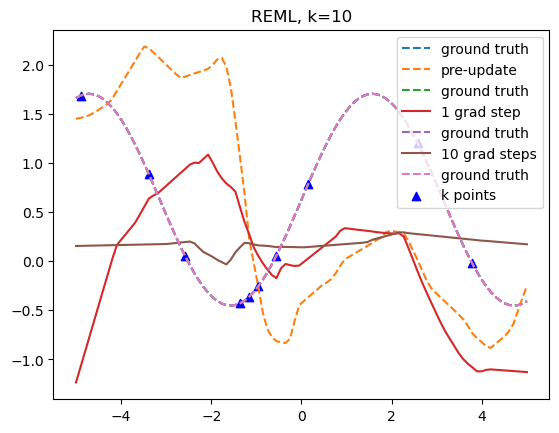

In [234]:
reml = REML(layer_pool=pool, tasks=tasks)
reml.model.load(path)
env = reml.make_env(eval_task)
reml.model.set_env(env)
reml.env = env
reml.task = eval_task

# ground truth
plt.plot(eval_task.data, eval_task.targets, linestyle='--', label='ground truth')

# pre-update
reml.generate_sine_curve(env=env, args={'linestyle' : '--', 'label': 'pre-update'})

# k points 
plt.scatter(k_pairs[:, 0], k_pairs[:, 1], marker='^', color='b', label='k points')

# train for 1 grad step
reml.env.batch_size = k
obs, _ = reml.env.reset()
for _ in range(1):
    action, _ = reml.model.predict(obs)
    obs, _, _, _, _ = reml.env.step(action)
reml.generate_sine_curve(env=env, args={'label' :'1 grad step'})
    
# train for 10 grad steps
obs, _ = reml.env.reset()
for _ in range(10):
    action, _ = reml.model.predict(obs)
    obs, _, _, _, _ = reml.env.step(action)
reml.generate_sine_curve(env=env, args={'label' : '10 grad steps'})
plt.title('REML, k=10')

## episodic learning 

In [26]:
config['episodic'] = True
config

{'seed': 41,
 'device': 'cuda',
 'pretrain': False,
 'episodic': True,
 'epochs': 1,
 'timesteps': 500,
 'n_x': 100,
 'n_tasks': 6,
 'in_features': 1,
 'out_features': 1,
 'n_pool_hidden_layers': 18,
 'n_hidden_layers_per_network': 3,
 'n_layers_per_network': 5,
 'n_nodes_per_layer': 32,
 'pool_layer_type': torch.nn.modules.linear.Linear,
 'action_space_shape': (2,),
 'batch_size': 100,
 'learning_rate': 0.05,
 'action_cache_size': 5,
 'num_workers': 0,
 'loss_fn': MSELoss(),
 'sb3_model': 'RecurrentPPO',
 'sb3_policy': 'MlpLstmPolicy',
 'log_dir': 'wandb'}

In [27]:
tasks = [InnerNetworkTask(data=tasks_data[i], targets=tasks_targets[i], info=tasks_info[i]) for i in range(config['n_tasks'])]
eval_task = random.choice(list(tasks))
training_tasks = list(set(tasks) - {eval_task})
pool = LayerPool(layers=layers) if config['pretrain'] else LayerPool(layers=None)
reml = REML(layer_pool=pool, tasks=training_tasks)

[INFO] Epoch=1/1
[INFO] Task=1/5
[INFO] Task=2/5
[INFO] Task=3/5
[INFO] Task=4/5
[INFO] Task=5/5


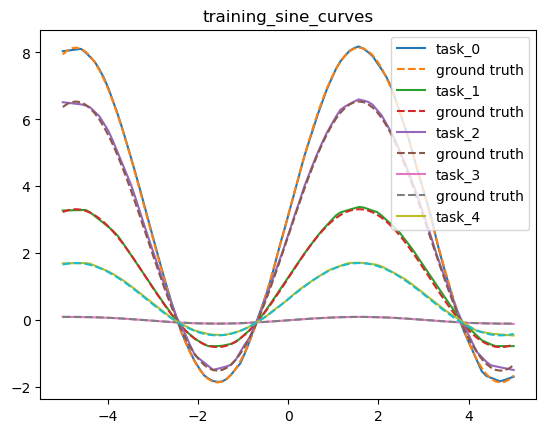

In [28]:
reml.train()
path = f"meta_episodic_{config['sb3_model']}_{datetime.datetime.now().strftime('%H-%M')}"
reml.model.save(path)

In [29]:
# get loss for meta trained network per step
reml = REML(layer_pool=pool, tasks=tasks)
reml.model.load(path)
meta_lossperstep_bytask = reml.evaluate_loss_curves()

# get loss for vanilla network per step
vanilla_lossperstep_bytask = {}
for task, x, y in zip(tasks, tasks_data, tasks_targets):
    model = RegressionModel()
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'])
    model.train()
    vanilla_lossperstep_bytask[task] = []
    for epoch in range(100):
        optimizer.zero_grad() 
        outputs = model(x.view(-1, 1))
        loss = criterion(outputs, y.view(-1,1))
        loss.backward()
        optimizer.step()
        vanilla_lossperstep_bytask[task].append(loss)


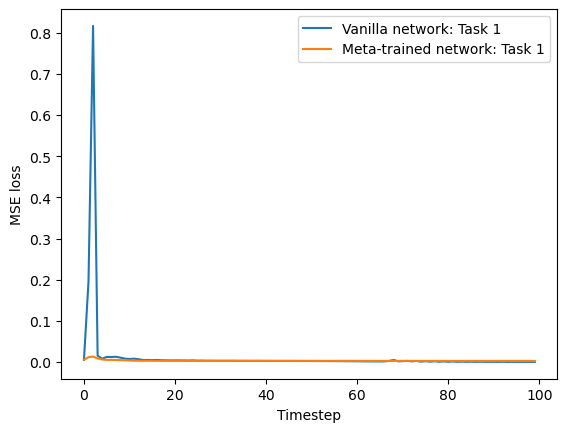

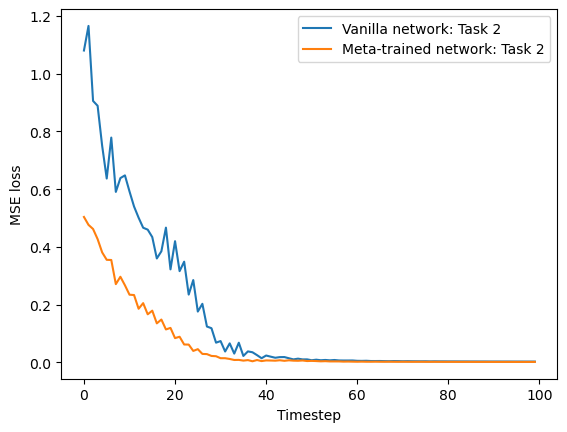

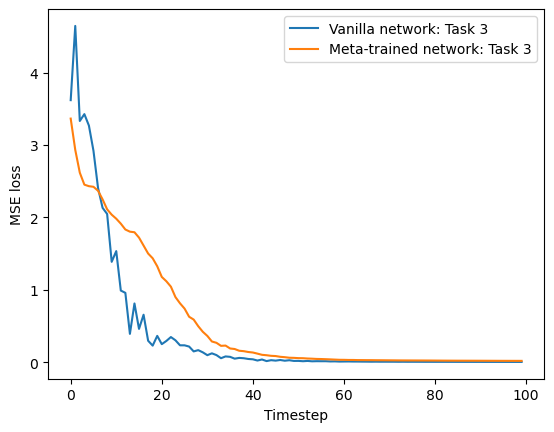

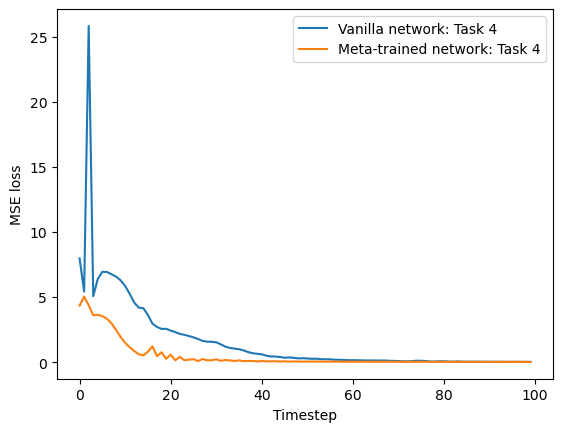

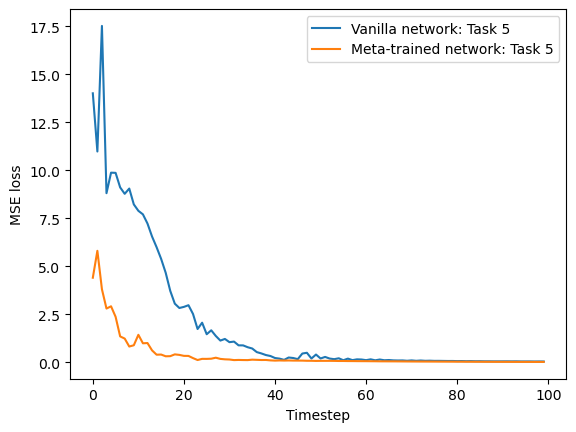

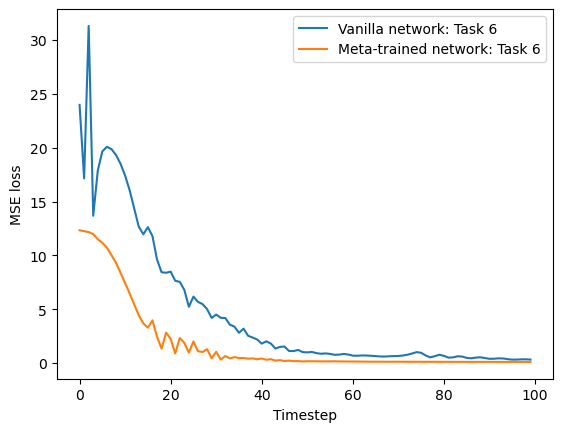

In [30]:
for i, (x, y) in enumerate(zip(tasks_data, tasks_targets)):
    task = tasks[i]
    vanilla_label = f'Vanilla network: Task {i+1}' 
    meta_label = f'Meta-trained network: Task {i+1}' 
    meta_loss_vals = [val.detach().numpy() for val in meta_lossperstep_bytask[task]]
    vanilla_loss_vals = [val.detach().numpy() for val in vanilla_lossperstep_bytask[task]]
    plt.plot(range(100), vanilla_loss_vals, label=vanilla_label)
    plt.plot(range(100), meta_loss_vals, label=meta_label)
    plt.xlabel('Timestep')
    plt.ylabel('MSE loss')
    plt.legend()
    plt.show()


#### k=5

In [31]:
k = 5
k_pairs = torch.tensor(random.sample(list(zip(eval_task.data, eval_task.targets)), k))
print(len(k_pairs))
print(k_pairs)

5
tensor([[ 3.9899, -0.3955],
        [-4.0909,  4.3565],
        [ 1.4646,  4.9078],
        [ 2.6768,  3.2477],
        [-4.8990,  4.8722]])


Text(0.5, 1.0, 'REML, k=5')

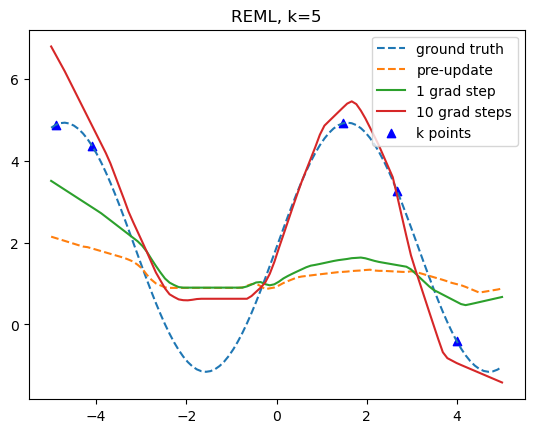

In [32]:
# env with eval task
reml = REML(layer_pool=pool, tasks=tasks)
reml.model.load(path)
env = reml.make_env(eval_task, pool)
reml.model.set_env(env)
reml.env = env
reml.task = eval_task

# ground truth
plt.plot(eval_task.data, eval_task.targets, linestyle='--', label='ground truth')

# pre-update
reml.generate_sine_curve(env=env, args={'linestyle' : '--', 'label': 'pre-update'})

# k points 
plt.scatter(k_pairs[:, 0], k_pairs[:, 1], marker='^', color='b', label='k points')

# train for 1 grad step
reml.env.batch_size = k
obs, _ = reml.env.reset()
for _ in range(1):
    action, _ = reml.model.predict(obs)
    obs, _, _, _, _ = reml.env.step(action)
reml.generate_sine_curve(env=env, args={'label' :'1 grad step'})
    
# train for 10 grad steps
obs, _ = reml.env.reset()
for _ in range(10):
    action, _ = reml.model.predict(obs)
    obs, _, _, _, _ = reml.env.step(action)
reml.generate_sine_curve(env=env, args={'label' : '10 grad steps'})
plt.title('REML, k=5')